Random Forest Results: MAE: 96713.4445, RMSE: 99235.6770
SVR Results: MAE: 55155.7546, RMSE: 56231.5324
Epoch 1/20, Loss: 6511008850.0137
Epoch 2/20, Loss: 6502050407.9817
Epoch 3/20, Loss: 6493545455.0114
Epoch 4/20, Loss: 6485344495.3043
Epoch 5/20, Loss: 6477944619.3501
Epoch 6/20, Loss: 6470136377.7025
Epoch 7/20, Loss: 6462533709.9130
Epoch 8/20, Loss: 6454136325.8581
Epoch 9/20, Loss: 6446977550.6453
Epoch 10/20, Loss: 6439053716.5034
Epoch 11/20, Loss: 6431075346.7460
Epoch 12/20, Loss: 6422236348.0458
Epoch 13/20, Loss: 6414856120.5309
Epoch 14/20, Loss: 6407405926.8101
Epoch 15/20, Loss: 6399831746.4897
Epoch 16/20, Loss: 6391537420.5950
Epoch 17/20, Loss: 6384230129.0618
Epoch 18/20, Loss: 6376469204.3570
Epoch 19/20, Loss: 6368286855.6156
Epoch 20/20, Loss: 6360549100.0824
CNN-GRU Results: MAE: 17894.4946, RMSE: 20958.6865


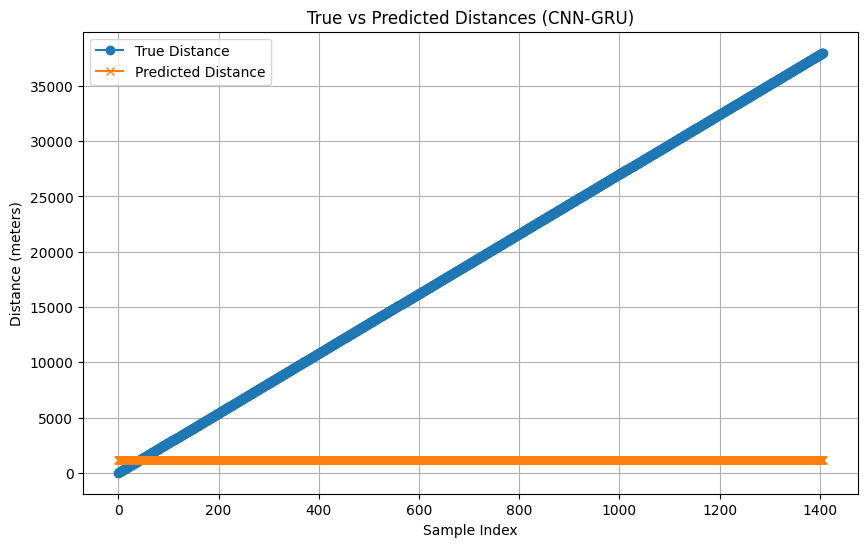

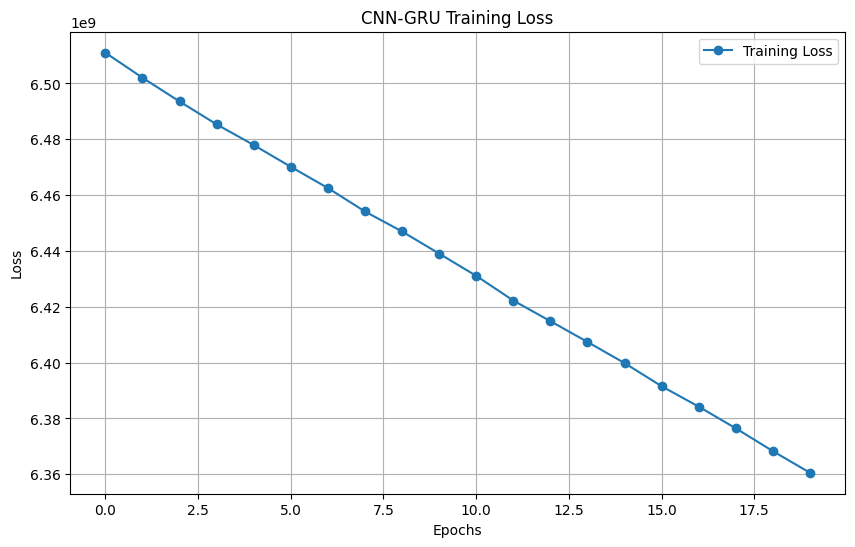

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Paths
train_base_dir = "/content/sample_data/A3Data/"
test_base_dir = "/content/sample_data/A4Data/"
motion_types = ['straight_slow', 'straight_fast', 'curve_slow', 'curve_fast']
datasets = ['Accelerometer']

# Helper Functions
def standardize_timestamp_column(df, dataset_name):
    if 'time' in df.columns:
        df.rename(columns={'time': 'timestamp'}, inplace=True)
    elif 'seconds_elapsed' in df.columns:
        df.rename(columns={'seconds_elapsed': 'timestamp'}, inplace=True)
    elif 'timestamp' not in df.columns:
        df['timestamp'] = pd.date_range(start='2023-01-01', periods=len(df), freq='100ms')
    df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    return df

def normalize(df, cols):
    return (df[cols] - df[cols].min()) / (df[cols].max() - df[cols].min())

def augment_data(df, jitter_std=0.01, scaling_factor_range=(0.9, 1.1), wrapping_factor_range=(0.8, 1.2)):
    augmented_dfs = []
    jittered_df = df.copy()
    jittered_df[['x', 'y', 'z']] += np.random.normal(0, jitter_std, df[['x', 'y', 'z']].shape)
    augmented_dfs.append(jittered_df)
    scaling_factor = np.random.uniform(*scaling_factor_range)
    scaled_df = df.copy()
    scaled_df[['x', 'y', 'z']] *= scaling_factor
    augmented_dfs.append(scaled_df)
    wrapping_factor = np.random.uniform(*wrapping_factor_range)
    warped_df = df.copy()
    warped_indices = np.round(np.linspace(0, len(df) - 1, int(len(df) * wrapping_factor))).astype(int)
    warped_indices = np.clip(warped_indices, 0, len(df) - 1)
    warped_df = df.iloc[warped_indices].reset_index(drop=True)
    augmented_dfs.append(warped_df)
    return augmented_dfs

def resample_and_process_dataset(df, target_frequency=30):
    df.set_index('timestamp', inplace=True)
    df = df.resample(f'{int(1000 / target_frequency)}ms').mean()
    df = df.interpolate(method='linear').reset_index()
    return df

def compute_velocity_and_distance(df, sampling_rate=30):
    velocity = np.cumsum(df[['x', 'y', 'z']].values, axis=0) * (1 / sampling_rate)
    distance = np.cumsum(np.sqrt(np.sum(velocity**2, axis=1))) * (1 / sampling_rate)
    return pd.DataFrame(velocity, columns=['vx', 'vy', 'vz']), distance

def merge_single_dataset(base_dir, motion_types, dataset, max_rows=None):
    merged_df = pd.DataFrame()
    if "A4Data" in base_dir:
        file_path = os.path.join(base_dir, f"{dataset}.csv")
        if os.path.exists(file_path):
            df = pd.read_csv(file_path)
            df = standardize_timestamp_column(df, dataset)
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    else:
        for motion in motion_types:
            file_path = os.path.join(base_dir, motion, f"{dataset}.csv")
            if os.path.exists(file_path):
                df = pd.read_csv(file_path)
                df = standardize_timestamp_column(df, dataset)
                if max_rows is not None:
                    df = df.head(max_rows)
                merged_df = pd.concat([merged_df, df], ignore_index=True)
    return merged_df

def process_all_datasets(base_dir, motion_types, datasets, max_rows=None):
    combined_data = {}
    for dataset in datasets:
        raw_data = merge_single_dataset(base_dir, motion_types, dataset, max_rows)
        if raw_data.empty:
            continue
        xyz_cols = [col for col in raw_data.columns if col in ['x', 'y', 'z']]
        raw_data[xyz_cols] = normalize(raw_data, xyz_cols)
        raw_data[xyz_cols] = savgol_filter(raw_data[xyz_cols], window_length=10, polyorder=2, axis=0)
        processed_data = resample_and_process_dataset(raw_data)
        velocity_df, distance = compute_velocity_and_distance(processed_data)
        processed_data[['vx', 'vy', 'vz']] = velocity_df
        processed_data['distance'] = distance
        combined_data[dataset] = processed_data.dropna()
    return combined_data

# CNN-GRU Model
class CNN_GRU_Model(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(CNN_GRU_Model, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveMaxPool1d(output_size=1)
        )
        self.gru = nn.GRU(input_size=32, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        _, h_n = self.gru(x)
        return self.fc(h_n[-1])

def train_and_test(train_combined, test_combined, epochs=20, batch_size=32):
    train_data = pd.concat(train_combined.values())
    test_data = pd.concat(test_combined.values())
    train_data['distance'] = np.cumsum([5] * len(train_data))
    test_data['distance'] = np.cumsum([27] * len(test_data))

    X_train = train_data[['x', 'y', 'z']].values
    y_train = train_data['distance'].values
    X_test = test_data[['x', 'y', 'z']].values
    y_test = test_data['distance'].values

    # Random Forest and SVR Models
    rfr = RandomForestRegressor(n_estimators=100, random_state=42)
    rfr.fit(X_train, y_train)
    y_pred_rfr = rfr.predict(X_test)
    svr = SVR(kernel='rbf', C=10, epsilon=0.1)
    svr.fit(X_train, y_train)
    y_pred_svr = svr.predict(X_test)

    mae_rfr = mean_absolute_error(y_test, y_pred_rfr)
    rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
    mae_svr = mean_absolute_error(y_test, y_pred_svr)
    rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))

    print(f"Random Forest Results: MAE: {mae_rfr:.4f}, RMSE: {rmse_rfr:.4f}")
    print(f"SVR Results: MAE: {mae_svr:.4f}, RMSE: {rmse_svr:.4f}")

    # CNN-GRU Model
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

    model = CNN_GRU_Model(input_dim=3, output_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    train_losses = []
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

    # Evaluate CNN-GRU
    model.eval()
    y_pred_test = []
    y_true_test = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred_test.extend(model(X_batch).squeeze().tolist())
            y_true_test.extend(y_batch.tolist())

    mae_cnn_gru = mean_absolute_error(y_true_test, y_pred_test)
    rmse_cnn_gru = np.sqrt(mean_squared_error(y_true_test, y_pred_test))
    print(f"CNN-GRU Results: MAE: {mae_cnn_gru:.4f}, RMSE: {rmse_cnn_gru:.4f}")

    # Plotting results
    plt.figure(figsize=(10, 6))
    plt.plot(y_true_test, label="True Distance", marker='o')
    plt.plot(y_pred_test, label="Predicted Distance", marker='x')
    plt.title("True vs Predicted Distances (CNN-GRU)")
    plt.xlabel("Sample Index")
    plt.ylabel("Distance (meters)")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss", marker='o')
    plt.title("CNN-GRU Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()



# Main Execution
if __name__ == "__main__":
    train_combined = process_all_datasets(train_base_dir, motion_types, datasets)
    test_combined = process_all_datasets(test_base_dir, [], datasets)
    train_and_test(train_combined, test_combined)
